In [300]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from sklearn import linear_model
from random import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import wikipedia
import warnings
import random

from bs4 import BeautifulSoup
import requests
import re
from fuzzywuzzy import fuzz

In [2]:
df_music = pd.read_csv('../music_data/dataset-12-1.csv')

In [3]:
df_music.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,987.000000,987.000000,987,987,987.000000,9.870000e+02,987.000000
unique,NaN,NaN,543,975,NaN,NaN,NaN
top,NaN,NaN,The Beatles,Dedicated To The One I Love,NaN,NaN,NaN
freq,NaN,NaN,23,2,NaN,NaN,NaN
mean,50.496454,11.708669,NaN,NaN,1964.513678,8.002504e+06,3367.725431
std,28.955074,12.776220,NaN,NaN,2.879346,2.003319e+07,3953.667139
min,1.000000,4.786301,NaN,NaN,1960.000000,1.728000e+03,108.000000
25%,25.000000,5.761896,NaN,NaN,1962.000000,2.501365e+05,951.000000
50%,50.000000,7.562751,NaN,NaN,1965.000000,9.563520e+05,1953.000000
75%,75.500000,11.949771,NaN,NaN,1967.000000,5.058133e+06,4194.000000


# 0 Utility

In [4]:
def z_score_norm(df, feature_list):
    """ Do the z-score method on selected features in feature_list. 
        z = (x - mean)/std

    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())
        
        
        
def do_log(df, feature_list):
    '''Do logarithm on selected features in feature_list.
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    '''
    
    for col in feature_list:
        df[col] = np.log(df[col])
        
        
        
def powerlaw_rank(df_music):
    ''' Do powerlaw on the original rank.
        y = 100*rank^(-0.66)
        However, I find that differnent coefficient and exponent do not affect MAE. Don't know why.
    
    Args:
        df_music (pandas.DataFrame): dataset
    '''
    
    df_music.insert(1, 'RankPowerlaw', df_music.Rank)  # insert right next to column 'Rank'
    df_music['RankPowerlaw'] = df_music['RankPowerlaw'].astype('float')
    for i in range(0, len(df_music)):
        df_music.iat[i,1] = 100 * math.pow(df_music.iat[i,1], -0.66)

In [5]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    
    
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name)
    
    

def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    #ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name)
    
    
    
def permutation_test(model,target,pred):
    '''do permuation tests
    
    Args:
        model_name: model
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae  = mean_absolute_error(target,pred)
    mae_list=[mae]
    count=0
    while count<100:
        count = count+1 
        target_to_list = target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle = mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins)
    ax.set_title('Permutation test')
    ax.set_xlabel('$Log(playcount)-mae$', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    
    
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    #permutation_test(model, target, pred)
    
    performance_statistics(model_name, target, pred)    

# 1 Baseline

In [6]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114


In [7]:
do_log(df_music, feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount'])

In [8]:
z_score_norm(df_music, feature_list=['Rank', 'RankPowerlaw', 'Year', 'WikiWordCount'])

In [9]:
feature = df_music.loc[:,['RankPowerlaw', 'Year', 'WikiWordCount']]
target  = df_music.loc[:,['SpotifyPlayCount']]

In [10]:
lr = linear_model.LinearRegression()

In [11]:
reg = linear_model.Ridge (alpha = .8)

This is the plots/reports of LinearRegression


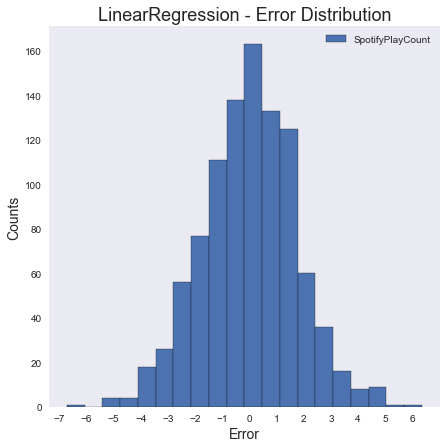

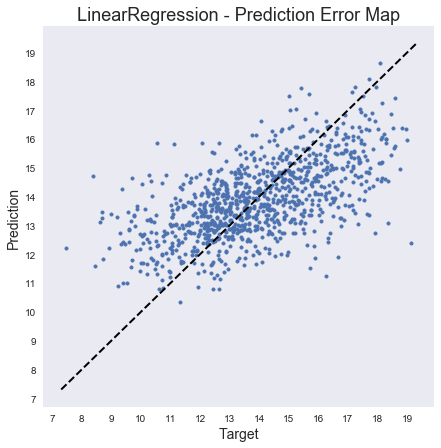

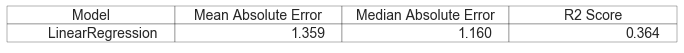

In [12]:
evaluation(lr, feature, target)

In [13]:
pred = cross_val_predict(lr, X=feature, y=target, cv=10)  # default is 10-fold

# Twenty Best

In [14]:
best = target - pred

In [15]:
best.insert(0, 'Prediction', pred)

In [16]:
best.insert(0, 'Target', target)

In [17]:
best.describe()

,Target,Prediction,SpotifyPlayCount
count,987.000000,987.000000,987.000000
mean,13.894324,13.896237,-0.001914
std,2.169542,1.314378,1.729986
min,7.454720,10.356239,-6.344982
25%,12.429750,12.999553,-1.173167
50%,13.770881,13.796711,-0.077178
75%,15.436479,14.753006,1.148544
max,19.119101,18.645882,6.719538


In [18]:
best_index = best.nlargest(20, columns='SpotifyPlayCount').index

In [19]:
best.nlargest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
826,19.119101,12.399562,6.719538
91,18.355697,13.073865,5.281832
259,17.907229,12.733936,5.173293
125,16.255563,11.233304,5.022259
180,16.674597,11.904866,4.769731
276,17.717049,13.351527,4.365522
842,17.322973,13.051946,4.271027
872,17.636537,13.412611,4.223926
230,15.707082,11.514579,4.192503
179,15.887576,11.870127,4.017449


In [20]:
df_music.iloc[best_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
826,1.260696,-0.897742,Marvin Gaye and Tammi Terrell,Ain't No Mountain High Enough,0.863502,19.119101,-1.174632
91,1.018942,-0.806925,Sam Cooke,Wonderful World,-1.567605,18.355697,0.368054
259,0.431826,-0.548283,Ben E. King,Stand By Me,-1.220304,17.907229,-0.296113
125,0.017391,-0.319503,Billy Bland,Let The Little Girl Dance,-1.567605,16.255563,-1.928709
180,1.640595,-1.026644,Maurice Williams and the Zodiacs,Stay,-1.567605,16.674597,-0.879462
276,1.536986,-0.992983,Dave Brubeck,Take Five,-1.220304,17.717049,0.584854
842,-0.086218,-0.253867,Scott Mckenzie,San Francisco (Be Sure to Wear Flowers in Your...,0.863502,17.322973,-0.934510
872,1.053478,-0.820375,Cream,White Room,1.210803,17.636537,-0.370465
230,-0.362508,-0.056471,Marcels,Blue Moon,-1.220304,15.707082,-1.803164
179,1.606059,-1.015540,Barrett Strong,Money,-1.567605,15.887576,-0.919181


In [21]:
lr2 = linear_model.LinearRegression()

In [22]:
lr2.fit(feature, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
feature.head()

,RankPowerlaw,Year,WikiWordCount
0,3.937389,-1.567605,-0.494041
1,3.186936,-1.567605,0.734592
2,2.747948,-1.567605,0.705613
3,0.254995,-1.567605,0.705613
4,-0.662354,-1.567605,0.705613


In [24]:
lr2.coef_

array([[ 0.59059588,  0.40435267,  1.02011652]])

# Twenty Worst

In [25]:
best.nsmallest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
737,8.377471,14.722454,-6.344982
578,10.539509,15.873371,-5.333862
864,9.691964,14.651270,-4.959306
515,9.375601,14.253891,-4.878290
519,8.679822,13.454378,-4.774556
227,7.454720,12.209741,-4.755021
715,11.114401,15.813829,-4.699428
520,8.678632,13.258019,-4.579388
174,8.603371,13.105400,-4.502030
959,10.271043,14.732205,-4.461162


In [26]:
worst_index = best.nsmallest(20, columns='SpotifyPlayCount').index

In [27]:
df_music.iloc[worst_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
737,1.709667,-1.048517,Paul Revere and The Raiders,Let Me,1.558105,8.377471,0.718370
578,0.224608,-0.439925,The Temptations,"Run Away Child, Running Wild",1.558105,10.539509,1.511440
864,1.433377,-0.958242,Bill Cosby,Little Ole Man (Uptight-Everything's Alright),0.863502,9.691964,1.030056
515,-1.087770,0.749516,The Ray Charles Singers,Love Me with All Your Heart (Cuando Calienta E...,-0.178401,9.375601,-0.039515
519,0.569971,-0.614930,The Dave Clark Five,Can't You See That She's Mine,-0.178401,8.679822,-0.030932
227,-0.500653,0.057600,Linda Scott,Don't Bet Money Honey,-1.220304,7.454720,-1.181268
715,-1.329524,1.247041,Roger Williams,Born Free,0.516201,11.114401,0.915937
520,1.398841,-0.946409,The Dave Clark Five,Do You Love Me,-0.178401,8.678632,-0.030932
174,1.295232,-0.910115,Annette Funicello,O Dio Mio,-1.567605,8.603371,0.207344
959,-0.327972,-0.083205,Bobby Sherman,Little Woman,1.558105,10.271043,0.240497


# 2 One Hot Encoding

In [252]:
df = pd.DataFrame({'Genre':['pop', 'r&b', 'country','pop', 'r&b', 'country','folk', 'rock and row'],
                   'WordCount': np.random.randn(8,)})

In [253]:
df

,Genre,WordCount
0,pop,0.590215
1,r&b,-0.213398
2,country,0.760691
3,pop,-0.133835
4,r&b,0.060788
5,country,-0.418949
6,folk,1.199795
7,rock and row,0.026890


In [254]:
pd.get_dummies(df.Genre)

,country,folk,pop,r&b,rock and row
0,0,0,1,0,0
1,0,0,0,1,0
2,1,0,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0
5,1,0,0,0,0
6,0,1,0,0,0
7,0,0,0,0,1


# 3 Add Followers and PopIndex to Dataframe

In [446]:
df_music = pd.read_csv('../music_data/dataset-12-4-temp.csv')

In [447]:
df_music.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Tar-Pre
count,987.000000,987.000000,987.000000,9.870000e+02,987.000000,9.870000e+02,987.000000,987.000000
mean,50.496454,11.708669,1964.513678,8.033249e+06,3359.658561,3.070148e+05,50.770010,-0.010171
std,28.955074,12.776220,2.879346,2.004466e+07,3957.353059,8.630158e+05,19.024026,1.602364
min,1.000000,4.786301,1960.000000,1.728000e+03,108.000000,1.900000e+01,4.000000,-5.784526
25%,25.000000,5.761896,1962.000000,2.501365e+05,951.000000,4.236000e+03,36.000000,-1.037573
50%,50.000000,7.562751,1965.000000,9.736140e+05,1952.000000,2.805400e+04,52.000000,0.046983
75%,75.500000,11.949771,1967.000000,5.136933e+06,4169.000000,1.207250e+05,65.000000,1.113530
max,100.000000,100.000000,1969.000000,2.010574e+08,19546.000000,5.042014e+06,89.000000,5.398892


In [448]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,Tar-Pre
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180,9877,52,easy listening,1.902780
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240,59717,59,"country, pop",1.337102
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114,120725,63,pop,0.983759
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114,120725,63,pop,-0.806677
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114,120725,63,pop,-0.664555


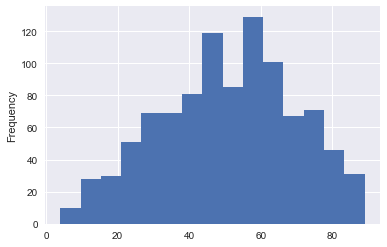

In [377]:
df_music.popularity.plot.hist(bins=15)

In [449]:
df_music2 = df_music.copy()

Do log to the following features:
1. SpotifyPlayCount (target)
2. RankPowerlaw
3. WikiWordCount
4. Followers

In [450]:
df_music2.SpotifyPlayCount = np.log(df_music2.SpotifyPlayCount)
df_music2.RankPowerlaw = np.log(df_music2.Followers)
df_music2.WikiWordCount = np.log(df_music2.WikiWordCount)
df_music2.Followers = np.log(df_music2.Followers)

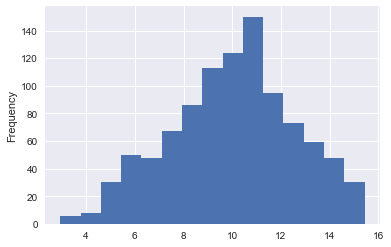

In [383]:
df_music2.Followers.plot.hist(bins=15)

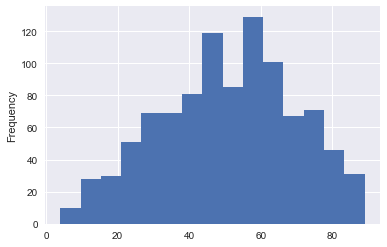

In [384]:
df_music2.Popularity.plot.hist(bins=15)

In [451]:
df_music2.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,Tar-Pre
0,1,9.197964,Percy Faith,"Theme From ""A Summer Place""",1960,15.425179,7.073270,9.197964,52,easy listening,1.902780
1,2,10.997372,Jim Reeves,He'll Have To Go,1960,15.291952,8.352319,10.997372,59,"country, pop",1.337102
2,3,11.701271,The Everly Brothers,Cathy's Clown,1960,15.246003,8.322151,11.701271,63,pop,0.983759
3,30,11.701271,The Everly Brothers,Let It Be Me,1960,13.455567,8.322151,11.701271,63,pop,-0.806677
4,70,11.701271,The Everly Brothers,So Sad,1960,13.597689,8.322151,11.701271,63,pop,-0.664555


In [452]:
df_music2.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Tar-Pre
count,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000
mean,50.496454,10.050829,1964.513678,13.898973,7.579075,10.050829,50.770010,-0.010171
std,28.955074,2.601363,2.879346,2.171788,1.049942,2.601363,19.024026,1.602364
min,1.000000,2.944439,1960.000000,7.454720,4.682131,2.944439,4.000000,-5.784526
25%,25.000000,8.351375,1962.000000,12.429750,6.857514,8.351375,36.000000,-1.037573
50%,50.000000,10.241887,1965.000000,13.788770,7.576610,10.241887,52.000000,0.046983
75%,75.500000,11.701271,1967.000000,15.451936,8.335431,11.701271,65.000000,1.113530
max,100.000000,15.433316,1969.000000,19.119101,9.880526,15.433316,89.000000,5.398892


Do z-score to the following feature
1. RankPowerlaw
2. Year
3. WikiWordCount
4. Followers
5. Popularity

In [453]:
feature_list = ['RankPowerlaw','Year', 'WikiWordCount', 'Followers', 'Popularity']
z_score_norm(df_music2, feature_list)

In [454]:
df_music2.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Tar-Pre
count,987.000000,9.870000e+02,9.870000e+02,987.000000,9.870000e+02,9.870000e+02,9.870000e+02,987.000000
mean,50.496454,-5.255843e-17,-2.273449e-14,13.898973,3.276451e-15,-5.255843e-17,-3.096139e-17,-0.010171
std,28.955074,1.000000e+00,1.000000e+00,2.171788,1.000000e+00,1.000000e+00,1.000000e+00,1.602364
min,1.000000,-2.731795e+00,-1.567605e+00,7.454720,-2.759147e+00,-2.731795e+00,-2.458471e+00,-5.784526
25%,25.000000,-6.532938e-01,-8.730030e-01,12.429750,-6.872390e-01,-6.532938e-01,-7.763872e-01,-1.037573
50%,50.000000,7.344527e-02,1.689002e-01,13.788770,-2.347950e-03,7.344527e-02,6.465455e-02,0.046983
75%,75.500000,6.344528e-01,8.635024e-01,15.451936,7.203795e-01,6.344528e-01,7.480010e-01,1.113530
max,100.000000,2.069103e+00,1.558105e+00,19.119101,2.191980e+00,2.069103e+00,2.009564e+00,5.398892


In [455]:
target = df_music2.loc[:,'SpotifyPlayCount']
feature_list = ['RankPowerlaw', 'WikiWordCount', 'Followers', 'Popularity', 'Year']
feature = df_music2.loc[:, feature_list]

In [456]:
lr = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


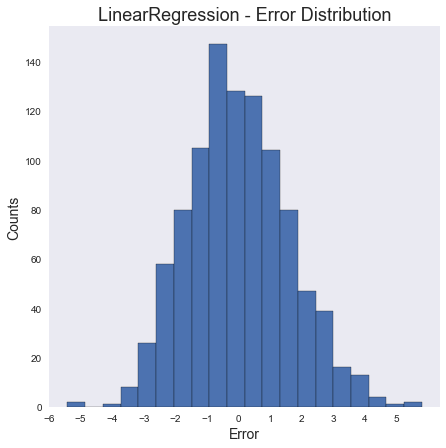

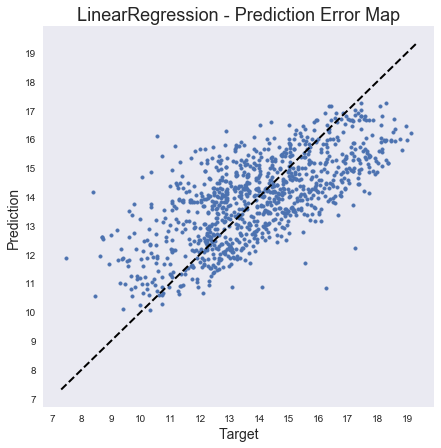

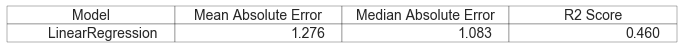

In [457]:
evaluation(lr, feature, target)

In [458]:
pred = cross_val_predict(lr, X=feature, y=target, cv=10)

In [459]:
best = target - pred
best = pd.DataFrame(best)

In [ ]:
best.insert(0, 'Prediction', pred)
best.insert(0, 'Target', target)
#best.nlargest(20, columns='SpotifyPlayCount')

In [461]:
best_index = best.nlargest(20, columns='SpotifyPlayCount').index
df_music.iloc[best_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,Tar-Pre
125,51,7.464551,Billy Bland,Let The Little Girl Dance,1960,11473647,265,210,14,NaN,5.398892
556,51,7.464551,Stan Getz and Astrud Gilberto,The Girl from Ipanema,1964,31119332,1553,1311,30,"bossa nova, jazz",5.017247
87,27,11.357949,Dinah Washington and Brook Benton,Baby (You've Got What It Takes),1960,5561544,1481,109712,30,r&b,3.835441
276,95,4.951108,Dave Brubeck,Take Five,1961,49478497,3623,46769,61,west coast cool jazz,3.613510
592,99,4.818155,The Kingsmen,Louie Louie,1964,28476446,2634,10771,51,garage rock,3.451428
331,53,7.277428,Booker T. and The M.G.'s,Green Onions,1962,41562698,3484,62586,59,NaN,3.369417
180,98,4.850548,Maurice Williams and the Zodiacs,Stay,1960,17445583,790,6296,49,doo-wop,3.302414
514,97,4.883494,Billy J. Kramer and The Dakotas,Bad to Me,1964,1302962,1328,444,9,"pop, beat",3.211533
572,10,21.877616,The Temptations,My Girl,1965,150297031,9521,663199,73,"soul, r&b",3.241240
91,80,5.545754,Sam Cooke,Wonderful World,1960,93708300,2898,471335,74,"rhythm and blues, soul",3.217315


# Add Genres to DataFrame

In [417]:
df_genres = pd.read_csv('../music_data/genres.csv')

In [418]:
df_genres = genres.loc[:, ['GenreRaw']]

In [419]:
df_genres.head()

,GenreRaw
0,easy listening
1,"country, pop"
2,pop
3,pop
4,pop


In [422]:
df_music3 = df_music.copy()

In [424]:
df_music3['GenreRaw'] = df_genres

In [462]:
df_music3['Tar-Pre'] = best.SpotifyPlayCount

In [430]:
df_music3.head(20)

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,Tar-Pre
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180,9877,52,easy listening,1.902780
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240,59717,59,"country, pop",1.337102
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114,120725,63,pop,0.983759
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114,120725,63,pop,-0.806677
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114,120725,63,pop,-0.664555
5,91,5.093692,The Everly Brothers,When Will I Be Loved,1960,508098,4114,120725,63,country,-1.123814
6,57,6.936216,The Everly Brothers,Walk Right Back,1961,2192314,4114,120725,63,rock,0.218692
7,47,7.877990,The Everly Brothers,Crying In The Rain,1962,3014478,4114,120725,63,rock,0.417630
8,4,40.053494,Johnny Preston,Running Bear,1960,1444980,444,2592,38,NaN,1.684545
9,45,8.107365,Johnny Preston,Cradle Of Love,1960,232921,444,2592,38,rock and roll,-0.140607


In [463]:
best_index = best.nlargest(50, columns='SpotifyPlayCount').index
df_music3.iloc[best_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,Tar-Pre
125,51,7.464551,Billy Bland,Let The Little Girl Dance,1960,11473647,265,210,14,NaN,5.418777
556,51,7.464551,Stan Getz and Astrud Gilberto,The Girl from Ipanema,1964,31119332,1553,1311,30,"bossa nova, jazz",5.021615
87,27,11.357949,Dinah Washington and Brook Benton,Baby (You've Got What It Takes),1960,5561544,1481,109712,30,r&b,3.834596
276,95,4.951108,Dave Brubeck,Take Five,1961,49478497,3623,46769,61,west coast cool jazz,3.607561
592,99,4.818155,The Kingsmen,Louie Louie,1964,28476446,2634,10771,51,garage rock,3.447218
331,53,7.277428,Booker T. and The M.G.'s,Green Onions,1962,41562698,3484,62586,59,NaN,3.361649
180,98,4.850548,Maurice Williams and the Zodiacs,Stay,1960,17445583,790,6296,49,doo-wop,3.307431
514,97,4.883494,Billy J. Kramer and The Dakotas,Bad to Me,1964,1302962,1328,444,9,"pop, beat",3.221353
572,10,21.877616,The Temptations,My Girl,1965,150297031,9521,663199,73,"soul, r&b",3.221272
91,80,5.545754,Sam Cooke,Wonderful World,1960,93708300,2898,471335,74,"rhythm and blues, soul",3.202694


In [464]:
worst_index = best.nsmallest(50, columns='SpotifyPlayCount').index
df_music3.iloc[worst_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,Tar-Pre
737,100,4.786301,Paul Revere and The Raiders,Let Me,1969,4348,4169,27075,47,NaN,-5.796158
578,57,6.936216,The Temptations,"Run Away Child, Running Wild",1969,37779,9521,663199,73,psychedelic soul,-5.571239
539,38,9.064479,The Animals,The House of the Rising Sun,1964,44557,3699,457784,71,rock,-4.701099
778,91,5.093692,Lou Rawls,Your Good Thing (Is About To End),1969,23102,2941,38644,54,r&b,-4.619346
21,70,6.056689,Brenda Lee,Coming On Strong,1966,69312,2547,56596,72,pop,-4.615563
100,23,12.625821,Bobby Darin,You're The Reason I'm Living,1963,30498,3068,99662,65,pop,-4.526582
227,36,9.393779,Linda Scott,Don't Bet Money Honey,1961,1728,577,1343,29,pop,-4.429725
699,96,4.917009,Jack Jones,The Race Is On,1965,17712,1803,12684,48,easy listening,-3.955581
520,91,5.093692,The Dave Clark Five,Do You Love Me,1964,5876,1911,18351,30,NaN,-3.920371
519,67,6.234342,The Dave Clark Five,Can't You See That She's Mine,1964,5883,1911,18351,30,beat,-3.919180


In [466]:
best_index = best.nlargest(987, columns='SpotifyPlayCount').index
df_music4 = df_music3.iloc[best_index, :]

In [478]:
df_music4 = pd.read_csv('../music_data/dataset-12-4-order.csv')

In [479]:
df_music4.dropna(how='any', inplace=True)

In [481]:
df_music4.to_csv('../music_data/dataset-12-4-order-dropna.csv', index=False)

In [483]:
df_music4.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,GenreClean,Tar-Pre
count,716.000000,716.000000,716,716,716.000000,7.160000e+02,716.000000,7.160000e+02,716.000000,716,716,716.000000
unique,NaN,NaN,403,708,NaN,NaN,NaN,NaN,NaN,267,258,NaN
top,NaN,NaN,The Beatles,Wonderful World,NaN,NaN,NaN,NaN,NaN,pop,pop,NaN
freq,NaN,NaN,22,2,NaN,NaN,NaN,NaN,NaN,98,98,NaN
mean,47.793296,12.560221,NaN,NaN,1964.837989,9.940095e+06,3837.706704,3.869685e+05,53.776536,NaN,NaN,0.217666
std,29.092604,13.749057,NaN,NaN,2.803396,2.177792e+07,4301.858640,9.743909e+05,18.307561,NaN,NaN,1.551279
min,1.000000,4.786301,NaN,NaN,1960.000000,1.728000e+03,163.000000,3.100000e+01,6.000000,NaN,NaN,-5.571239
25%,22.000000,5.891243,NaN,NaN,1963.000000,3.936418e+05,1069.000000,7.688750e+03,42.000000,NaN,NaN,-0.750713
50%,46.000000,7.990608,NaN,NaN,1965.000000,1.688771e+06,2192.500000,3.882900e+04,55.000000,NaN,NaN,0.343733
75%,73.000000,13.001727,NaN,NaN,1967.000000,7.850908e+06,4607.000000,2.016568e+05,67.000000,NaN,NaN,1.367217


In [645]:
#for i in range(0, len(df_music4)):
keyword = 'pop rock'

counter = 0
for i in range(0, 716):
    song = df_music4.iloc[i, :]
    genre = song.GenreClean
    if genre.find(keyword) != -1:
        counter = counter + 1
print(counter)


counter = 0
for i in range(0, 358):
    song = df_music4.iloc[i, :]
    genre = song.GenreClean
    if genre.find(keyword) != -1:
        counter = counter + 1
print(counter)

counter = 0
for i in range(0, 100):
    song = df_music4.iloc[i, :]
    genre = song.GenreClean
    if genre.find(keyword) != -1:
        counter = counter + 1
print(counter)

counter = 0
for i in range(0, 20):
    song = df_music4.iloc[i, :]
    genre = song.GenreClean
    if genre.find(keyword) != -1:
        counter = counter + 1
print(counter)

counter = 0
for i in range(616, 716):
    song = df_music4.iloc[i, :]
    genre = song.GenreClean
    if genre.find(keyword) != -1:
        counter = counter + 1
print(counter)

counter = 0
for i in range(696, 716):
    song = df_music4.iloc[i, :]
    genre = song.GenreClean
    if genre.find(keyword) != -1:
        counter = counter + 1
print(counter)

48
21
7
0
5
2


In [490]:
len(df_music4)

716

# Furthur Cleaning & Impute Missing Value

In [613]:
df_music5 = pd.read_csv('../music_data/dataset-12-4-order.csv')

In [614]:
df_music5['GenreClean2'] = df_music5.GenreClean

In [604]:
def match(genre):
    dic = {}
    if genre.find('r&b') != -1:
        dic['r&b'] = 1
    else:
        dic['r&b'] = 0
    if genre.find('soul') != -1:
        dic['soul'] = 1
    else:
        dic['soul'] = 0
    if genre.find('doo-wop') != -1:
        dic['doo-wop'] = 1
    else:
        dic['doo-wop'] = 0
    
    if genre.find('pop') != -1:
        dic['pop'] = 1
    else:
        dic['pop'] = 0
    if genre.find('rock') != -1:
        dic['rock'] = 1
    else:
        dic['rock'] = 0
        
    return dic

In [605]:
match('r&b, soul')

{'doo-wop': 0, 'pop': 0, 'r&b': 1, 'rock': 0, 'soul': 1}

In [615]:
df_music5.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,GenreClean,TarPre,GenreClean2
0,51,7.464551,Billy Bland,Let The Little Girl Dance,1960,11473647,265,210,14,NaN,NaN,5.418777,NaN
1,51,7.464551,Stan Getz and Astrud Gilberto,The Girl from Ipanema,1964,31119332,1553,1311,30,"bossa nova, jazz","bossa nova, jazz",5.021615,"bossa nova, jazz"
2,27,11.357949,Dinah Washington and Brook Benton,Baby (You've Got What It Takes),1960,5561544,1481,109712,30,r&b,r&b,3.834596,r&b
3,95,4.951108,Dave Brubeck,Take Five,1961,49478497,3623,46769,61,west coast cool jazz,west coast cool jazz,3.607561,west coast cool jazz
4,99,4.818155,The Kingsmen,Louie Louie,1964,28476446,2634,10771,51,garage rock,garage rock,3.447218,garage rock


soul -> r&b (or pop if worst)

In [616]:
nan_counter = 0
for i in range(0, len(df_music5)):
#for i in range(17, 18):
    song = df_music5.iloc[i, :]
    genre = song.GenreClean2
    try:
        dic = match(genre)
        #print(dic)
        if dic['r&b'] == 1 or dic['soul'] == 1:
            if dic['pop'] == 0:
                #print('caitao')
                song.GenreClean2 = 'r&b'
            else:
                tar_pre = song.TarPre
                #print(tar_pre)
                if tar_pre > 0:
                    song.GenreClean2 = 'r&b'
                else:
                    song.GenreClean2 = 'pop'
            df_music5.iloc[i, :] = song
    except Exception as e:
        #print(song.Title, ': genre nan')
        counter = counter + 1

D:\Program Files\anaconda\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [622]:
df_music5.to_csv('../music_data/dataset-12-4-clean1.csv', index=False)

doo-wop --> r&b

In [620]:
nan_counter = 0
for i in range(0, len(df_music5)):
#for i in range(17, 18):
    song = df_music5.iloc[i, :]
    genre = song.GenreClean2
    try:
        dic = match(genre)
        #print(dic)
        if dic['doo-wop'] == 1:
            if dic['pop'] == 0:
                song.GenreClean2 = 'r&b'
            else:
                tar_pre = song.TarPre
                if tar_pre > 0:
                    song.GenreClean2 = 'r&b'
                else:
                    song.GenreClean2 = 'pop'
            df_music5.iloc[i, :] = song
    except Exception as e:
        #print(song.Title, ': genre nan')
        counter = counter + 1

D:\Program Files\anaconda\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [640]:
df_music5 = pd.read_csv('../music_data/dataset-12-4-clean2.csv')

In [641]:
counter = 0
for i in range(0, len(df_music5)):
    song = df_music5.iloc[i, :]
    genre = song.GenreClean2
    try:
        if genre.find('garage rock') != 1:
            song.GenreClean = rock
            df_music5.iloc[i, :] = song
    except Exception as e:
        #print(song.Title, ': genre nan')
        counter = counter + 1

In [642]:
counter

987

In [643]:
df_music5.to_csv('../music_data/dataset-12-4-clean2.csv', index=False)

In [633]:
df_music5.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,TarPre
count,987.000000,987.000000,987.000000,9.870000e+02,987.000000,9.870000e+02,987.000000,987.000000
mean,50.496454,11.708669,1964.513678,8.002504e+06,3359.658561,3.070148e+05,50.770010,-0.010217
std,28.955074,12.776220,2.879346,2.003319e+07,3957.353059,8.630158e+05,19.024026,1.596176
min,1.000000,4.786301,1960.000000,1.728000e+03,108.000000,1.900000e+01,4.000000,-5.796158
25%,25.000000,5.761896,1962.000000,2.501365e+05,951.000000,4.236000e+03,36.000000,-1.027409
50%,50.000000,7.562751,1965.000000,9.563520e+05,1952.000000,2.805400e+04,52.000000,0.058037
75%,75.500000,11.949771,1967.000000,5.058133e+06,4169.000000,1.207250e+05,65.000000,1.102428
max,100.000000,100.000000,1969.000000,2.010574e+08,19546.000000,5.042014e+06,89.000000,5.418777


## Impute Missing Value

In [669]:
df_music6 = pd.read_csv('../music_data/dataset-12-4-clean2.csv')

In [670]:
df_music6.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,GenreClean,TarPre,GenreClean2
count,986.000000,986.000000,986,986,986.000000,9.860000e+02,986.000000,9.860000e+02,986.000000,715,718,986.000000,811
unique,NaN,NaN,543,974,NaN,NaN,NaN,NaN,NaN,267,258,NaN,16
top,NaN,NaN,The Beatles,Baby It's You,NaN,NaN,NaN,NaN,NaN,pop,pop,NaN,r&b
freq,NaN,NaN,23,2,NaN,NaN,NaN,NaN,NaN,97,98,NaN,221
mean,50.511156,11.711017,NaN,NaN,1964.517241,8.010619e+06,3362.480730,3.073248e+05,50.792089,NaN,NaN,-0.005735,NaN
std,28.966082,12.782491,NaN,NaN,2.878629,2.004174e+07,3958.367503,8.633988e+05,19.021024,NaN,NaN,1.590759,NaN
min,1.000000,4.786301,NaN,NaN,1960.000000,4.348000e+03,108.000000,1.900000e+01,4.000000,NaN,NaN,-5.796158,NaN
25%,25.000000,5.749304,NaN,NaN,1962.000000,2.516032e+05,951.000000,4.236000e+03,36.250000,NaN,NaN,-1.025931,NaN
50%,50.000000,7.562751,NaN,NaN,1965.000000,9.649830e+05,1952.000000,2.805400e+04,52.000000,NaN,NaN,0.058640,NaN
75%,75.750000,11.949771,NaN,NaN,1967.000000,5.077456e+06,4169.000000,1.207250e+05,65.000000,NaN,NaN,1.104968,NaN


In [671]:
uniqueGenre = pd.Series(df_music6.GenreClean2)

In [672]:
uniqueGenre = uniqueGenre.dropna()

In [673]:
uniqueGenre.unique()

array(['r&b', 'jazz', 'rock', 'pop', 'sunshine pop', 'country',
       'hard rock', 'pop rock', 'beat', 'easy listening',
       'traditional pop', 'folk', 'rockabilly', 'instrumental', 'funk',
       'novelty'], dtype=object)

In [674]:
df_music6.groupby('GenreClean2').count()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,GenreClean,TarPre
GenreClean2,,,,,,,,,,,,
beat,17,17,17,17,17,17,17,17,17,14,14,17
country,47,47,47,47,47,47,47,47,47,43,43,47
easy listening,14,14,14,14,14,14,14,14,14,12,12,14
folk,14,14,14,14,14,14,14,14,14,14,14,14
funk,8,8,8,8,8,8,8,8,8,7,7,8
hard rock,16,16,16,16,16,16,16,16,16,16,16,16
instrumental,5,5,5,5,5,5,5,5,5,3,3,5
jazz,19,19,19,19,19,19,19,19,19,18,18,19
novelty,7,7,7,7,7,7,7,7,7,7,7,7


# Test Correlation Matrix

In [681]:
df_music7 = pd.read_csv('../music_data/../music_data/dataset-12-4-clean2.csv')

In [682]:
df_music7.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,GenreRaw,GenreClean,TarPre,GenreClean2
count,986.000000,986.000000,986,986,986.000000,9.860000e+02,986.000000,9.860000e+02,986.000000,715,718,986.000000,868
unique,NaN,NaN,543,974,NaN,NaN,NaN,NaN,NaN,267,258,NaN,16
top,NaN,NaN,The Beatles,Baby It's You,NaN,NaN,NaN,NaN,NaN,pop,pop,NaN,r&b
freq,NaN,NaN,23,2,NaN,NaN,NaN,NaN,NaN,97,98,NaN,236
mean,50.511156,11.711017,NaN,NaN,1964.517241,8.010619e+06,3362.480730,3.073248e+05,50.792089,NaN,NaN,-0.005735,NaN
std,28.966082,12.782491,NaN,NaN,2.878629,2.004174e+07,3958.367503,8.633988e+05,19.021024,NaN,NaN,1.590759,NaN
min,1.000000,4.786301,NaN,NaN,1960.000000,4.348000e+03,108.000000,1.900000e+01,4.000000,NaN,NaN,-5.796158,NaN
25%,25.000000,5.749304,NaN,NaN,1962.000000,2.516032e+05,951.000000,4.236000e+03,36.250000,NaN,NaN,-1.025931,NaN
50%,50.000000,7.562751,NaN,NaN,1965.000000,9.649830e+05,1952.000000,2.805400e+04,52.000000,NaN,NaN,0.058640,NaN
75%,75.750000,11.949771,NaN,NaN,1967.000000,5.077456e+06,4169.000000,1.207250e+05,65.000000,NaN,NaN,1.104968,NaN


In [683]:
df_music7 = df_music7.loc[:, ['SpotifyPlayCount', 'GenreClean2']]

In [685]:
df_music7.SpotifyPlayCount = np.log(df_music7.SpotifyPlayCount)

In [690]:
df_music7.dropna(inplace=True)

In [691]:
df_music7.describe(include='all')

,SpotifyPlayCount,GenreClean2
count,868.000000,868
unique,NaN,16
top,NaN,r&b
freq,NaN,236
mean,14.043802,NaN
std,2.185054,NaN
min,8.377471,NaN
25%,12.556939,NaN
50%,13.924930,NaN
75%,15.637236,NaN


In [693]:
dummy_genre = pd.get_dummies(df_music7.GenreClean2)

In [695]:
dummy_genre

,beat,country,easy listening,folk,funk,hard rock,instrumental,jazz,novelty,pop,pop rock,r&b,rock,rockabilly,sunshine pop,traditional pop
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [698]:
playcount_genre = df_music7.join(dummy_genre, how='outer')

In [699]:
playcount_genre

,SpotifyPlayCount,GenreClean2,beat,country,easy listening,folk,funk,hard rock,instrumental,jazz,novelty,pop,pop rock,r&b,rock,rockabilly,sunshine pop,traditional pop
0,16.255563,r&b,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,17.253340,jazz,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,15.531386,r&b,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,17.717049,jazz,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,17.164588,rock,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,17.542714,r&b,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,16.674597,r&b,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,14.080151,pop,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,18.828124,r&b,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,18.355697,r&b,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


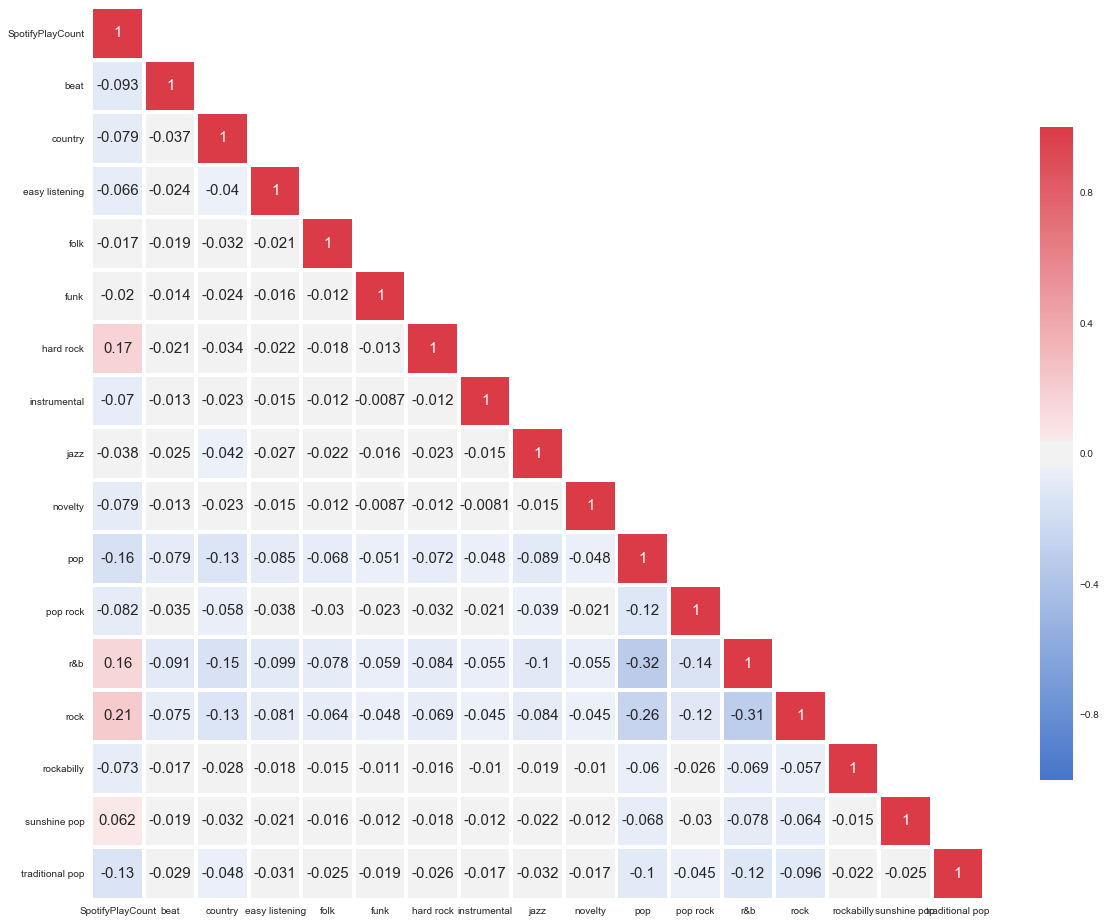

In [701]:
sns.set(style="white")
corr = playcount_genre.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})